In [2]:
import os 
import time
import pandas as pd


import keras 
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from keras import layers

from tensorflow.keras import backend as K
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score

In [47]:
train_data = pd.read_csv('./VF9CP2F3XBA142893.csv', index_col='ts')
test_data = pd.read_csv('./VF9BE896727200531.csv', index_col='ts')

<AxesSubplot:xlabel='ts'>

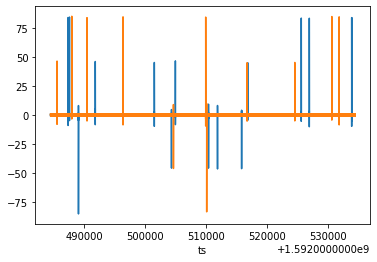

In [6]:
train_data['sensor_1'].plot()
test_data['sensor_1'].plot()

## Creation de modèle (LSTM AutoEncodeur)

In [7]:
def LSTMAE(nb_entries, width, loss="MSE"):
        """
        Sets up the architecture that will be used for the autoencoder
    
            Parameters: 
        
                nb_entries: an integer representing the number of rows of the spectrograms images
                width: an integer representing the number of columns of the spectrograms images
        
            Returns:
                model: convolutional autoencoder
        """
        valid_shape = (width, nb_entries)
        model = Sequential()
        model.add(LSTM(64, activation='relu', input_shape=valid_shape, return_sequences=True))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(units=10,activation="relu", name="latent"))
        model.add(BatchNormalization())
        model.add(Dense(32, activation='relu'))
        model.add(LSTM(64, activation='sigmoid', return_sequences=True))
        model.add(TimeDistributed(Dense(nb_entries)))
        optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss=loss)
        return model

## Formatage et pre-processing de la donnée

In [8]:
def build_rolling_data(data,window):
    rolling_data = np.lib.stride_tricks.as_strided(data, (len(data) - window + 1, window),(data.strides[0], data.strides[0]))
    rolling_data = tf.expand_dims(rolling_data,axis=-1)
    return rolling_data

In [48]:
WINDOW_SIZE = 30
scaler = MinMaxScaler() # instanciating a scaler 
# minmax scaler formula X_scaled = X-min(X) / max(X)-min(X)
# Scales data between 0 and 1
data_train = train_data['sensor_1'].values
data_test = test_data['sensor_1'].values
scaler.fit(data.reshape(-1,1))
normalized_train_data = scaler.transform(data_train.reshape(-1,1))
normalized_test_data = scaler.transform(data_test.reshape(-1,1))

In [12]:
# Build LSTM AutoEncoder for unidimentional time series
model = LSTMAE(1, WINDOW_SIZE)

In [13]:
start = time.time()
model.fit(rolling_normalized_data,rolling_normalized_data,epochs= 20, verbose = True, batch_size=128)
print(f"model trained in {(time.time()-start)/60} minutes")

Epoch 1/20
391/391 [==============================] - 14s 31ms/step - loss: 0.0026
Epoch 2/20
391/391 [==============================] - 12s 31ms/step - loss: 1.8627e-05
Epoch 3/20
391/391 [==============================] - 12s 31ms/step - loss: 4.0641e-06
Epoch 4/20
391/391 [==============================] - 18s 47ms/step - loss: 1.4666e-06
Epoch 5/20
391/391 [==============================] - 13s 34ms/step - loss: 1.3163e-06
Epoch 6/20
391/391 [==============================] - 15s 39ms/step - loss: 1.3649e-06
Epoch 7/20
391/391 [==============================] - 17s 42ms/step - loss: 1.7902e-06
Epoch 8/20
391/391 [==============================] - 14s 35ms/step - loss: 9.4901e-06
Epoch 9/20
391/391 [==============================] - 17s 42ms/step - loss: 2.0883e-05
Epoch 10/20
391/391 [==============================] - 14s 36ms/step - loss: 2.5069e-05
Epoch 11/20
391/391 [==============================] - 14s 36ms/step - loss: 2.4587e-05
Epoch 12/20
391/391 [========================

## Prediction 

In [24]:
def predict_anomalies(model,data, sigma):
    rolling_data = build_rolling_data(data,WINDOW_SIZE)
    predicted = model.predict(rolling_data)
    reconstruction_error = np.mean((rolling_data-predicted)**2, axis =1)
    # the threshold is the  average of reconstruction error + 3 std reconstruction error
    # The predicted anomalies are the points with a decision inferior to 0 <=> reconstruction error > threshold
    decision = -reconstruction_error + np.mean(reconstruction_error)+sigma*np.std(reconstruction_error)
    padding = [0]*(len(data)-len(decision)) # creating a padding for the decision list to match size of initial data
    return list(decision.flatten()) + padding


In [53]:
train_data['predict'] = predict_anomalies(model,Normalized_data,1.5)
# the anomalies are the points with an initial predict value inferior to 0
train_data['predict'] = train_data['predict'].apply(lambda x : 25 if x < 0 else 0)

<AxesSubplot:xlabel='ts'>

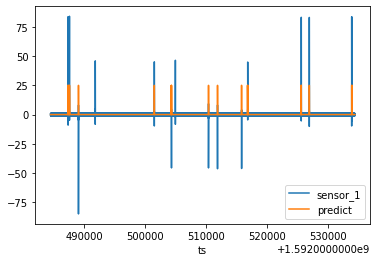

In [54]:
train_data[['sensor_1','predict']].plot()

In [51]:
test_data['predict']= predict_anomalies(model,normalized_test_data,1.5)
# the anomalies are the points with an initial predict value inferior to 0
# make the prediction visible by setting normal predicted values to zero and predicted anomalies to 25 ( for visibility in the visual validation ) 
test_data['predict'] = test_data['predict'].apply(lambda x : 25 if x < 0 else 0)

<AxesSubplot:xlabel='ts'>

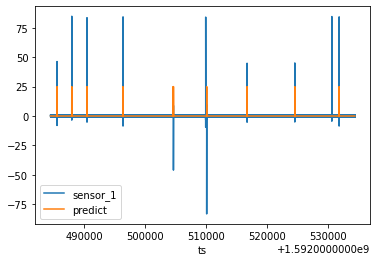

In [52]:
test_data[['sensor_1','predict']].plot()